# Imports

In [1]:
import os
import json
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import torchvision
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision.io import read_image
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import Dataset, DataLoader
from torchmetrics.detection.map import MeanAveragePrecision
from PIL import Image
import pycocotools

In [2]:
# Imports local modules downloaded from TorchVision repo v0.8.2, references/detection
# https://github.com/pytorch/vision/tree/v0.8.2/references/detection
import utils
import transforms
import coco_eval
from engine import train_one_epoch, evaluate

In [3]:
# Imports from local lib files
from coco_utils import get_coco_api_from_dataset
from coco_eval import CocoEvaluator
from engine import _get_iou_types 

# Functions and initiations

## File paths

In [4]:
# Set the paths to the annotation files that will retrieve the images with the split based on the annotations
output_path = 'output'
img_folder = 'eccv_18_all_images_sm'
cis_test_ann_path = 'eccv_18_annotation_files/cis_test_annotations.json'
cis_val_ann_path = 'eccv_18_annotation_files/cis_val_annotations.json'
train_ann_path = 'eccv_18_annotation_files/train_annotations.json'
trans_test_ann_path = 'eccv_18_annotation_files/trans_test_annotations.json'
trans_val_ann_path = 'eccv_18_annotation_files/trans_val_annotations.json'

# Load the json files of the annotations for better exploring of each images
cis_test_ann = json.load(open(cis_test_ann_path))
cis_val_ann = json.load(open(cis_val_ann_path))
train_ann = json.load(open(train_ann_path))
trans_test_ann = json.load(open(trans_test_ann_path))
trans_val_ann = json.load(open(trans_val_ann_path))

## Utils

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

### Transformation

In [6]:
# Make and horizontal flip data transformation with 50% chance to use as data augmentation in a data loader
# In paper :  ' ... and employ horizontal flipping for data augmentation. ( for detection)

import transforms as T   # from git hub repo

data_transform = {'train': T.RandomHorizontalFlip(0.5)}

### Images and dataset

In [7]:
# Method that returns a list with the idx of images with at least one bounding box (img_wbbox) and a 
# list with the number of bbox for each valid image (num_bbox)
def get_img_with_bbox(file_path):
  
    file = json.load(open(file_path))
    img_wbbox = []
    num_bbox = []

    for i in range(len(file['images'])):
        bboxes = [file['annotations'][j]['bbox'] 
                  for j in range(len(file['annotations'])) 
                  if file['annotations'][j]['image_id']==file['images'][i]['id'] 
                  and 'bbox' in file['annotations'][j].keys()]

        if len(bboxes)!=0:
            img_wbbox.append(i)

            num_bbox.append(len(bboxes))

    return img_wbbox, num_bbox

In [8]:
# Class used to create a custom dataset
class CustomImageDataset(Dataset):
    def __init__(self, label_path, img_dir, valid_img, transform = None):
        self.label_file = json.load(open(label_path))
        self.img_dir = img_dir
        self.transform = transform
        self.valid_img = valid_img

    def __len__(self):
        return len(self.valid_img)

    def __getitem__(self, idx):
        
        idx = self.valid_img[idx] # consider only images with bbox annotations
        img_path = os.path.join(self.img_dir, self.label_file['images'][idx]['file_name'])
        image = read_image(img_path)

        conv = torchvision.transforms.ToTensor()
        # if image.shape[0]==1:
        # some images have only one channel, we convert them to rgb
        image = Image.open(img_path).convert("RGB")
        image = conv(image)

        boxes = [self.label_file['annotations'][j]['bbox'] 
                 for j in range(len(self.label_file['annotations'])) 
                 if self.label_file['annotations'][j]['image_id']==self.label_file['images'][idx]['id']]
        
        label = [self.label_file['annotations'][j]['category_id'] 
                 for j in range(len(self.label_file['annotations'])) 
                 if self.label_file['annotations'][j]['image_id']==self.label_file['images'][idx]['id']]

        # transform bbox coords to adjust for resizing
        scale_x = image.shape[2] / self.label_file['images'][idx]['width'] 
        scale_y = image.shape[1] / self.label_file['images'][idx]['height']

        boxes = torch.as_tensor(boxes)
        for i in range(boxes.shape[0]):
            boxes[i][0] = torch.round(boxes[i][0] * scale_x)
            boxes[i][1] = torch.round(boxes[i][1] * scale_y)
            boxes[i][2] = torch.round(boxes[i][2] * scale_x)
            boxes[i][3] = torch.round(boxes[i][3] * scale_y)

            boxes[i][2] = boxes[i][0] + boxes[i][2] # to transform to pytorch bbox format
            boxes[i][3] = boxes[i][1] + boxes[i][3]

        label = torch.as_tensor(label)
        label = torch.where(label==30,0,1)  # 0 if empty (categ id = 30), 1 if animal
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = label
        target["image_id"] = image_id
        target['area']=area
        target['iscrowd']=iscrowd

        if self.transform:
            # transform image AND target
            image, target = self.transform(image, target)

        return image, target

## Create the model

### Pre-trained models
Inspred from https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/torchvision_finetuning_instance_segmentation.ipynb#scrollTo=YjNHjVMOyYlH

### Model with only the last layer to train (CNN layers)

In [9]:
# Get a pretrained model and set to train the last layer (CNN : model 1)
def get_model_from_pretrained_cnn(num_classes):

    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    for param in model.parameters(): # to freeze all existing weights
        param.requires_grad = False

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

# Get a pretrained model and set to train the last 2 layers (ROI + CNN : model 2)
def get_model_from_pretrained_roi(num_classes):

    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    for param in model.parameters(): # to freeze all existing weights
        param.requires_grad = False

    for param in model.roi_heads.parameters():
        param.requires_grad = True

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

# Get a pretrained model and set to train the last 3 layers (RPN + ROI + CNN : model 3)
def get_model_from_pretrained_rpn(num_classes):

    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    for param in model.parameters(): # to freeze all existing weights

        param.requires_grad = False

    for param in model.roi_heads.parameters():

        param.requires_grad = True

    for param in model.rpn.parameters():

        param.requires_grad = True

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [10]:
# Create a model based on a type preference between the 3 proposed
def create_model(model_type, num_classes=2, milestones=[5, 10]):

    # our dataset has two classes only - background and person
    num_classes = num_classes

    # get the model from the type we want using our helper function
    if model_type==1 or model_type=='cnn':
        model = get_model_from_pretrained_cnn(num_classes)
    elif model_type==2 or model_type=='roi':
        model = get_model_from_pretrained_roi(num_classes)
    elif model_type==3 or model_type=='rpn':
        model = get_model_from_pretrained_rpn(num_classes)
    else:
        return 'Please select a valid model. 1:CNN - 2:ROI - 3:RPN'

    # move model to the right device
    model.to(device)

    # construct an SGD optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.0003, momentum=0.9)

    # like in the paper, construct the scheduler
    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = milestones, gamma=0.1)
    
    return model, optimizer, lr_scheduler

# Save the model, the optimizer and the scheduler into 3 separate files (~165MB)
def save_model(file_name = time.strftime("%Y%m%d_%H%M%S")):
    filename = file_name

    torch.save(model.state_dict(), 'saved_models/' + filename + '_model.pt')
    torch.save(optimizer.state_dict(), 'saved_models/' + filename + '_optimizer.pt')
    torch.save(lr_scheduler.state_dict(), 'saved_models/' + filename + '_scheduler.pt')

def load_model(model_type, model_type_file_name, num_classes=2, milestones=[5, 10]):
    model, optimizer, lr_scheduler = create_model(model_type, num_classes, milestones)
    
    # load the model, the optimizer and the scheduler
    model.load_state_dict(torch.load('saved_models/' + model_type_file_name + '_model.pt'))
    optimizer.load_state_dict(torch.load('saved_models/' + model_type_file_name + '_optimizer.pt'))
    lr_scheduler.load_state_dict(torch.load('saved_models/' + model_type_file_name + '_scheduler.pt'))
    
    return model, optimizer, lr_scheduler

## Create the dataloaders
To load the data of the dataset efficiently for the model

In [11]:
def create_dataloader(ann_path, batch_size, shuffle=True, transform=None):
    images_with_bbox,_ = get_img_with_bbox(ann_path)
    data = CustomImageDataset(ann_path, img_folder, images_with_bbox, transform)
    return DataLoader(data, batch_size=batch_size, shuffle=shuffle, collate_fn=utils.collate_fn)

## Define the 'evaluate' fonction

In [12]:
# TODO: méthode pour évaluer 
def evaluate(dataloader, coco, nms=True, iou=0.35):
    apply_nms = nms
    iou_threshold = iou # param to potentially tune (threshold for nms)
    the_data_loader = dataloader # change to test set
    
    iou_types = _get_iou_types(model)
    coco_evaluator = CocoEvaluator(coco, iou_types)

    model.eval()

    for images, targets in the_data_loader:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with torch.no_grad():

            pred=model(images)

            if apply_nms:
                boxes_to_keep = torchvision.ops.nms(pred[0]['boxes'], pred[0]['scores'], iou_threshold=iou_threshold).cpu()
                pred[0]['boxes'] = pred[0]['boxes'][boxes_to_keep]
                pred[0]['labels'] = pred[0]['labels'][boxes_to_keep]
                pred[0]['scores'] = pred[0]['scores'][boxes_to_keep]

            outputs = [{k: v.cpu() for k, v in t.items()} for t in pred]
            res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
            coco_evaluator.update(res)
    
    coco_evaluator.synchronize_between_processes()
    coco_evaluator.accumulate()
    coco_evaluator.summarize()
    return coco_evaluator

## Logs utils

#### Train logs utils

In [13]:
# Converts the smoothed values to a dictionnary of each values
def smoothed_value_to_str(smoothed_value):
    d_values = {}
    d_values['median'] = smoothed_value.median
    d_values['avg'] = smoothed_value.avg
    d_values['global_avg'] = smoothed_value.global_avg
    d_values['max'] = smoothed_value.max
    d_values['value'] = smoothed_value.value
    return d_values


# Converts the train logs from MetricLogger to list
def train_logs_to_lst(logs):
    lst = []
    for i in range(len(logs)):
        d = {}
        for key in logs[i].meters.keys():
            d[key] = smoothed_value_to_str(logs[i].meters[key])
        lst.append(d)
    return lst


# Puts the training logs into a json file with time dependent file name
def train_logs_to_json(logs, ftime=time.strftime("%Y%m%d_%H%M%S")):
    train_metric_logs = train_logs_to_lst(logs)
    filename = ftime + "_train_logs.json"
    
    with open('saved_logs/' + filename, 'w', encoding='utf-8') as f:
        json.dump(train_metric_logs, f, ensure_ascii=False, indent=4)

In [14]:
# Converts the train logs from MetricLogger to list
def train_logs_to_lst(logs):
    lst = []
    for i in range(len(logs)):
        d = {}
        for key in logs[i].meters.keys():
            d[key] = smoothed_value_to_str(logs[i].meters[key])
        lst.append(d)
    return lst

In [15]:
# Puts the training logs into a json file with time dependent file name
def train_logs_to_json(logs, ftime=time.strftime("%Y%m%d_%H%M%S")):
    train_metric_logs = train_logs_to_lst(logs)
    filename = ftime + "_train_logs.json"
    
    with open('saved_logs/' + filename, 'w', encoding='utf-8') as f:
        json.dump(train_metric_logs, f, ensure_ascii=False, indent=4)

#### Valid logs utils

In [16]:
# Merge the dicts of a list 
def merge_dict(logs):
    logs_better = []
    try:
        for i in range(len(logs)):
            logs_better.append({**logs[i][0], **logs[i][1], **logs[i][2], **logs[i][3]})
        return logs_better
    except:
        print(logs[0])
        logs_better = logs
        return logs_better

In [17]:
# Converts the valid logs from list of dictionnaries to string
# TODO: add if type == list to not do anything if its already a list
def valid_logs_to_lst(valid_logs):
    logs = merge_dict(valid_logs)
    lst = []
    for i in range(len(logs)):
        d = {}
        for key in logs[i].keys():
            d[key] = logs[i][key].cpu().numpy().tolist()
        lst.append(d)
    return lst

In [18]:
# Puts the cis validation logs into a json file with time dependent file name
def cis_valid_logs_to_json(logs, ftime=time.strftime("%Y%m%d_%H%M%S")):
    valid_metric_logs = valid_logs_to_lst(logs)
    filename = ftime + "_cis_valid_logs.json"
    
    with open('saved_logs/' + filename, 'w', encoding='utf-8') as f:
        json.dump(valid_metric_logs, f, ensure_ascii=False, indent=4)

In [19]:
# Puts the trans validation logs into a json file with time dependent file name
def trans_valid_logs_to_json(logs, ftime=time.strftime("%Y%m%d_%H%M%S")):
    valid_metric_logs = valid_logs_to_lst(logs)
    filename = ftime + "_trans_valid_logs.json"
    
    with open('saved_logs/' + filename, 'w', encoding='utf-8') as f:
        json.dump(valid_metric_logs, f, ensure_ascii=False, indent=4)

# Training the model

In [20]:
# Defining the train function
def train(dataloader, num_epochs, save_logs=True, save_model=True, print_freq=100):
    
    model.train()
    
    all_train_logs = []
    all_cis_valid_logs = []
    all_trans_valid_logs = []

    for epoch in range(num_epochs):
        
        # train for one epoch, printing every 100 images
        train_logs = train_one_epoch(model, optimizer, dataloader, device, epoch, print_freq)
        all_train_logs.append(train_logs)
        
        # update the learning rate
        lr_scheduler.step()
        
        # evaluate on the validation dataset after training one epoch
        for images, targets in trans_valid_dataloader: # can do batch of 10 prob.
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            with torch.no_grad():
                trans_loss_dict = model(images, targets)
                trans_loss_dict = [{k: loss.to('cpu')} for k, loss in trans_loss_dict.items()]
                all_trans_valid_logs.append(trans_loss_dict)


        for images, targets in cis_valid_dataloader: # can do batch of 10 prob.
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            with torch.no_grad():
                cis_loss_dict = model(images, targets)
                cis_loss_dict = [{k: loss.to('cpu')} for k, loss in cis_loss_dict.items()]
                all_cis_valid_logs.append(cis_loss_dict)
    
    filetime = time.strftime("%Y%m%d_%H%M%S")
    
    if save_logs:
        
        # save the train, cis valid and trans valid logs
        train_logs_to_json(all_train_logs, filetime)
        cis_valid_logs_to_json(all_cis_valid_logs, filetime)
        trans_valid_logs_to_json(all_trans_valid_logs, filetime)
        
    if save_model:
        
        # save the model, the optimizer and the scheduler
        torch.save(model.state_dict(), 'saved_models/' + filetime + '_model.pt')
        torch.save(optimizer.state_dict(), 'saved_models/' + filetime + '_optimizer.pt')
        torch.save(lr_scheduler.state_dict(), 'saved_models/' + filetime + '_scheduler.pt')
    
    
    
    return all_train_logs, all_trans_valid_logs, all_cis_valid_logs


# Interactive Part

### Before training

In [21]:
# Set the lightweight configuration mode to use subset of data, simpler architecture and few epochs
# to quickly test the code for evaluation
lightweight_mode = 0

#### You can specify the data augmentation transformation at will

In [22]:
# Initiate the dataloaders with batch size from the paper for better comparison
if lightweight_mode:
    train_dataloader = create_dataloader(train_ann_path, 1, data_transform)
    cis_valid_dataloader = create_dataloader(cis_val_ann_path, 10)
    trans_valid_dataloader = create_dataloader(trans_val_ann_path, 10)
    cis_test_dataloader = create_dataloader(cis_test_ann_path, 10)
    trans_test_dataloader = create_dataloader(trans_test_ann_path, 10)
else:
    train_dataloader = create_dataloader(train_ann_path, 1, data_transform)
    cis_valid_dataloader = create_dataloader(cis_val_ann_path, 10)
    trans_valid_dataloader = create_dataloader(trans_val_ann_path, 10)
    cis_test_dataloader = create_dataloader(cis_test_ann_path, 10)
    trans_test_dataloader = create_dataloader(trans_test_ann_path, 10)

In [23]:
# Loads the test dataset for coco evaluation later on
cis_coco = get_coco_api_from_dataset(cis_test_dataloader.dataset)
trans_coco = get_coco_api_from_dataset(trans_test_dataloader.dataset)

creating index...
index created!
creating index...
index created!


#### Specify the model created

In [24]:
model, optimizer, lr_scheduler = create_model(3)

In [25]:
# Parameters before training
num_epochs = 10

# Check if using the right device before training
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1080 Ti'

### This next cell starts the training of the model

In [26]:
# TRAIN
all_train_logs, all_trans_valid_logs, all_cis_valid_logs = train(dataloader=train_dataloader, num_epochs=num_epochs)

C:\Users\kevin\miniconda3\envs\animals\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: [0]  [    0/12099]  eta: 8:27:02  lr: 0.000001  loss: 0.7460 (0.7460)  loss_classifier: 0.6163 (0.6163)  loss_box_reg: 0.0641 (0.0641)  loss_objectness: 0.0624 (0.0624)  loss_rpn_box_reg: 0.0032 (0.0032)  time: 2.5145  data: 0.0280  max mem: 594
Epoch: [0]  [  100/12099]  eta: 0:30:18  lr: 0.000031  loss: 0.2891 (0.4846)  loss_classifier: 0.1477 (0.3222)  loss_box_reg: 0.1105 (0.1217)  loss_objectness: 0.0158 (0.0332)  loss_rpn_box_reg: 0.0033 (0.0075)  time: 0.1276  data: 0.0311  max mem: 652
Epoch: [0]  [  200/12099]  eta: 0:29:27  lr: 0.000061  loss: 0.2473 (0.3768)  loss_classifier: 0.0959 (0.2154)  loss_box_reg: 0.1223 (0.1175)  loss_objectness: 0.0110 (0.0364)  loss_rpn_box_reg: 0.0039 (0.0075)  time: 0.1458  data: 0.0400  max mem: 652
Epoch: [0]  [  300/12099]  eta: 0:28:09  lr: 0.000091  loss: 0.2284 (0.3356)  loss_classifier: 0.0811 (0.1760)  loss_box_reg: 0.1169 (0.1189)  loss_objectness: 0.0046 (0.0330)  loss_rpn_box_reg: 0.0022 (0.0077)  time: 0.1299  data: 0.0331  m

KeyboardInterrupt: 

## Checking the log results

##### Ensures that if you hit the training cell, you don't lose the variables containing the logs from the last run

In [27]:
last_train_logs = all_train_logs
last_trans_valid_logs = all_trans_valid_logs
last_cis_valid_logs = all_cis_valid_logs

NameError: name 'all_train_logs' is not defined

##### Converts the logs to lists and the tensors to numpy 

In [ ]:
train_logs = train_logs_to_lst(last_train_logs)
cis_valid_logs = valid_logs_to_lst(last_cis_valid_logs)
trans_valid_logs = valid_logs_to_lst(last_trans_valid_logs)

## Results

In [ ]:
# To confirm that the data is loaded properly
n = len(train_logs)
print(n)

In [ ]:
num_epochs = len(train_logs)

In [ ]:
# Train loss to print (here we use global_avg but we can use: value, median, avg, max or global_avg)
results_train_loss = []

for i in range(n):
    results_train_loss.append(train_logs[i]['loss_box_reg']['global_avg'])
    
# Cis valid loss to print
results_cis_valid_loss = [] # cis

for i in range(n):
    loss_interm = 0
    for j in range(167):
        loss_interm += cis_valid_logs[(167 * i) + j]['loss_rpn_box_reg']
    results_cis_valid_loss.append(loss_interm)

# Trans valid loss to print
results_trans_valid_loss = [] # trans

for i in range(n):
    loss_interm = 0
    for j in range(154):
        loss_interm += trans_valid_logs[(154 * i) + j]['loss_rpn_box_reg']
    results_trans_valid_loss.append(loss_interm)

### Plots

In [ ]:
# Printing the different plots
fig, ax = plt.subplots(1,2, figsize=(20,6))

ax[0].plot(np.arange(1, n + 1), results_train_loss, label='train')
ax[0].set_title('Train loss per epoch')
ax[0].set_ylabel('loss_box_reg')
ax[0].set_xlabel('epoch')

plt.title('Train loss per epoch')
ax[1].plot(np.arange(1, n + 1), results_cis_valid_loss, label='cis')
ax[1].plot(np.arange(1, n + 1), results_trans_valid_loss, label='trans')
ax[1].set_title('Valid loss per epoch')
ax[1].set_ylabel('loss_rpn_box_reg')
ax[1].set_xlabel('epoch')
ax[1].legend()

#### Save the figure to pdf format in the figures folder

In [ ]:
fig.savefig("saved_figures/" + time.strftime("%Y%m%d_%H%M%S") + "_figure.pdf")

## Make Predictions with a model

### Load 10 random predictions

In [ ]:
# Loads 10 images and makes the model do predictions on these images
train_features, train_labels = next(iter(trans_valid_dataloader))
image = list(image.to(device) for image in train_features)

model.eval()
with torch.no_grad():
      pred = model(image)

In [ ]:
# Prints 10 images with the predictions before and after NMS
# TODO: faire des méthodes pour simplifier le code
for image_i in range(len(image)):
    fig, ax = plt.subplots(1,3,figsize=(24,16))

    ax[0].imshow(train_features[image_i][0].squeeze(),cmap="gray")
    rect = patches.Rectangle((train_labels[image_i]['boxes'][0][0], 
                              train_labels[image_i]['boxes'][0][1]), 
                             train_labels[image_i]['boxes'][0][2]-train_labels[image_i]['boxes'][0][0], 
                             train_labels[image_i]['boxes'][0][3]-train_labels[image_i]['boxes'][0][1], 
                             linewidth=2, edgecolor='r', facecolor='none')
    ax[0].add_patch(rect)
    ax[0].set_title('Ground truth')

    # Predictions
    ax[1].imshow(train_features[image_i][0].squeeze(),cmap="gray")
    for i in range(len(pred[image_i]['boxes'])):
        rect = patches.Rectangle((pred[image_i]['boxes'][i][0].cpu(), 
                                  pred[image_i]['boxes'][i][1].cpu()), 
                                 (pred[image_i]['boxes'][i][2]-pred[image_i]['boxes'][i][0]).cpu(), 
                                 (pred[image_i]['boxes'][i][3]-pred[image_i]['boxes'][i][1]).cpu(), 
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax[1].add_patch(rect)
    ax[1].set_title('Pred')

    # Predictions after NMS
    iou_threshold = 0.001 # param to tune
    boxes_to_keep = torchvision.ops.nms(pred[image_i]['boxes'], pred[image_i]['scores'], iou_threshold = iou_threshold).cpu()
    ax[2].imshow(train_features[image_i][0].squeeze(),cmap="gray")
    for i in boxes_to_keep:
        rect = patches.Rectangle((pred[image_i]['boxes'][i][0].cpu(), 
                                  pred[image_i]['boxes'][i][1].cpu()), 
                                 (pred[image_i]['boxes'][i][2]-pred[image_i]['boxes'][i][0]).cpu(), 
                                 (pred[image_i]['boxes'][i][3]-pred[image_i]['boxes'][i][1]).cpu(), 
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax[2].add_patch(rect)

    ax[2].set_title('After NMS')

In [ ]:
trans_val_ann['images'][train_labels[3]['image_id']]

In [ ]:
# Print a single image chosen by index from the last batch of 10 predictions
image_i = 3 # from 0 to 9 included

fig, ax = plt.subplots(1,3,figsize=(24,16))

ax[0].imshow(train_features[image_i][0].squeeze(),cmap="gray")
for i in range(len(train_labels[image_i]['boxes'])):
    rect = patches.Rectangle((train_labels[image_i]['boxes'][i][0], 
                            train_labels[image_i]['boxes'][i][1]), 
                            train_labels[image_i]['boxes'][i][2]-train_labels[image_i]['boxes'][i][0], 
                            train_labels[image_i]['boxes'][i][3]-train_labels[image_i]['boxes'][i][1], 
                            linewidth=2, edgecolor='r', facecolor='none')
    ax[0].add_patch(rect)
ax[0].set_title('Ground truth')

# Predictions
ax[1].imshow(train_features[image_i][0].squeeze(),cmap="gray")
for i in range(len(pred[image_i]['boxes'])):
    rect = patches.Rectangle((pred[image_i]['boxes'][i][0].cpu(), 
                              pred[image_i]['boxes'][i][1].cpu()), 
                             (pred[image_i]['boxes'][i][2]-pred[image_i]['boxes'][i][0]).cpu(), 
                             (pred[image_i]['boxes'][i][3]-pred[image_i]['boxes'][i][1]).cpu(), 
                             linewidth=2, edgecolor='r', facecolor='none')
    ax[1].add_patch(rect)
ax[1].set_title('Pred')

# Predictions after NMS
iou_threshold = 0.01 # param to tune
boxes_to_keep = torchvision.ops.nms(pred[image_i]['boxes'], pred[image_i]['scores'], iou_threshold = iou_threshold).cpu()
ax[2].imshow(train_features[image_i][0].squeeze(),cmap="gray")
for i in boxes_to_keep:
    rect = patches.Rectangle((pred[image_i]['boxes'][i][0].cpu(), 
                              pred[image_i]['boxes'][i][1].cpu()), 
                             (pred[image_i]['boxes'][i][2]-pred[image_i]['boxes'][i][0]).cpu(), 
                             (pred[image_i]['boxes'][i][3]-pred[image_i]['boxes'][i][1]).cpu(), 
                             linewidth=2, edgecolor='r', facecolor='none')
    ax[2].add_patch(rect)

ax[2].set_title('After NMS')

In [ ]:
boxes_to_keep

In [ ]:
pred[image_i]['boxes'][0]

In [ ]:
train_labels[image_i]['boxes']

# Evalutate on COCO detection metrics

### Test on COCO metrics from data loaders
##### 'For evaluation, we consider a detected box to be correct if its IoU ≥ 0.5 with a ground truth box.'

We need to look at the precison score with IoU=0.5, area=all and maxDets=100.
For the recall score, by default it's IoU=0.5:IoU=0.95.

In [ ]:
# cis test 10 epochs rpn + roi 3

In [ ]:
# takes +- 25min to run on cis_test
cis_coco_evaluator = evaluate(cis_test_dataloader, cis_coco)

In [ ]:
# takes +- 25min to run on cis_test
trans_coco_evaluator = evaluate(trans_test_dataloader, trans_coco)

In [ ]:
print('cis test 10 epochs rpn + roi 3')
print('_'*80)
cis_coco_evaluator.summarize()

In [ ]:
print('trans test 10 epochs rpn + roi 3')
print('_'*80)
trans_coco_evaluator.summarize()

# Methods

## Method 3 (Subspace alignment based Domain adaptation)

In [28]:
model, optimizer, lr_scheduler = load_model(3, "10_rpn_roi_4")

In [30]:
import torchvision.ops.boxes as bops
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from torch import nn

Papers 

 1. https://arxiv.org/pdf/1507.05578.pdf

 2.  https://openaccess.thecvf.com/content_iccv_2013/papers/Fernando_Unsupervised_Visual_Domain_2013_ICCV_paper.pdf

**Construct source matrix:** 

We keep output of model.roi_heads.box_head (vector of size 1024) as feature representations of bounding boxes extracted by the RPN (region proposal network). For us to stack a box representation to the source matrix, it has to have a IoU > thres_IoU with the ground truth of the given image. 

In [31]:
# 20 minutes
thres_IoU = 0.50
count = 0

X_source = torch.tensor([])
bbox_idx = torch.arange(1000)

model.eval()

for images, targets in train_dataloader: 
    images = [image.to(device) for image in images]
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    count += 1

    if count%100 == 0:
        print(count)

    with torch.no_grad():
        outputs = []
        hook = model.rpn.register_forward_hook(
        lambda self, input, output: outputs.append(output))

        outputs1 = []
        hook1 = model.roi_heads.box_head.register_forward_hook(
        lambda self, input, output: outputs1.append(output))

        res = model(images)
        hook.remove()
        hook1.remove()

    coords = outputs[0][0][0].cpu() # [1000,4]
    feat = outputs1[0].cpu() # [1000, 1024]

    gt = targets[0]['boxes'].cpu()

    bbox_idx_to_keep = torch.tensor([])
    for i in range(gt.shape[0]):

        IoUs = bops.box_iou(gt[i].reshape(1,4), coords)
        IoUs = IoUs.reshape(1000)
        bbox_idx_to_keep = torch.cat((bbox_idx_to_keep, bbox_idx[IoUs >= thres_IoU]),dim=0)

    X_source = torch.cat((X_source,feat[torch.unique(bbox_idx_to_keep).long()]), dim=0)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000


In [32]:
X_source.shape

torch.Size([101061, 1024])

### Save 1

In [33]:
torch.save(X_source, 'saved_matrixes/X_source_05_row_col_10_rpn_roi_4_512.pt')

In [ ]:
# # center data
# scaler = StandardScaler()
# X_source_scaled = scaler.fit_transform(X_source)

In [35]:
# center data per row
scaler_row = StandardScaler()
X_source_scaled_row = scaler_row.fit_transform(X_source.T)

# center data per column
scaler_col = StandardScaler()
X_source_scaled = scaler_col.fit_transform(X_source_scaled_row.T)

In [36]:
# Apply PCA, keep only an amount of first components which gives the Projected source matrix

pca = PCA(n_components=512)
pca.fit(X_source_scaled)

X_source_proj = pca.components_
X_source_proj = torch.from_numpy(X_source_proj)


In [37]:
X_source_proj.shape

torch.Size([512, 1024])

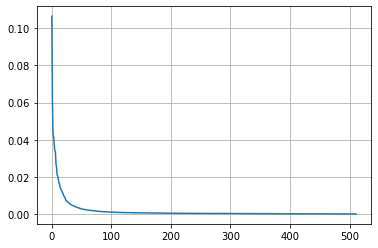

In [38]:
plt.plot(pca.explained_variance_ratio_) 
plt.grid()

### Save 2

In [39]:
torch.save(X_source_proj, 'saved_matrixes/X_source_proj_05_row_col_10_rpn_roi_4_512.pt')

### Target data with batch size 1

In [40]:
# Target data/distribution = trans test set - Batch Size 1
trans_test_batch1_img,_ = get_img_with_bbox(trans_test_ann_path)
trans_test_batch1_data = CustomImageDataset(trans_test_ann_path, img_folder, trans_test_batch1_img)
trans_test_batch1_dataloader = DataLoader(trans_test_batch1_data, batch_size=1, shuffle=True, collate_fn=utils.collate_fn)

 **Construct target matrix:** 
 
We keep output of model.roi_heads.box_head (vector of size 1024) as feature representations of bounding boxes
 extracted by the RPN (region proposal network). For us to stack a box representation to the source matrix, the predicted bbox associated with the feature has to have a confidence score > thres_conf_score (since we don't use target labels we can't use the IoU here).


In [ ]:
# 30 minutes
thres_conf_score= 0.50 
count=0

X_target=torch.tensor([])

model.eval()

for images, targets in trans_test_batch1_dataloader: # trans location valid AND test ?
    images = [image.to(device) for image in images]
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    count+=1

    if count%100==0:
        print(count)

    with torch.no_grad():

        outputs = []
        hook = model.backbone.register_forward_hook(
        lambda self, input, output: outputs.append(output))
        res = model(images)
        hook.remove()

        box_features = model.roi_heads.box_roi_pool(outputs[0], [r['boxes'] for r in res], [i.shape[-2:] for i in images])
        box_features = model.roi_heads.box_head(box_features)

    X_target = torch.cat((X_target,box_features[res[0]['scores']>=thres_conf_score].cpu()), dim=0)


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800


In [ ]:
X_target.shape

In [ ]:
torch.save(X_target, 'saved_matrixes/X_target_05_row_col_10_rpn_roi_4_512.pt')

In [ ]:
# # center data
# scaler = StandardScaler()
# X_target_scaled = scaler.fit_transform(X_target)

In [ ]:
# center data per row
scaler_row = StandardScaler()
X_target_scaled_row = scaler_row.fit_transform(X_target.T)

# center data per column
scaler_col = StandardScaler()
X_target_scaled = scaler_col.fit_transform(X_target_scaled_row.T)

In [ ]:
# Apply PCA, keep only an amount of first components which gives the Projected source matrix

pca_proj = PCA(n_components=512)
pca_proj.fit(X_target_scaled)

X_target_proj = pca_proj.components_
X_target_proj = torch.from_numpy(X_target_proj)

In [ ]:
plt.plot(pca_proj.explained_variance_ratio_) # we keep d dimensions
plt.grid()

In [ ]:
X_target_proj.shape

In [ ]:
torch.save(X_target_proj, 'saved_matrixes/X_target_proj_05_row_col_10_rpn_roi_4_512.pt')

### Transformation matrix M

𝑀 is obtained by minimizing the following Bregman matrix divergence (following closed-form solution given in the paper)

In [ ]:
M = torch.matmul(X_source_proj, X_target_proj.T) 

In [ ]:
M.shape

### Project source data into target aligned source subspace

In [ ]:
Xa = torch.matmul(X_source_proj.T,M)

In [ ]:
Xa.shape

In [ ]:
# To project a given feature

# feat(1,1024) x Xa (1024,100)

### Projet target data in target subspace

In [ ]:
# To project a given feature

# feat(1,1024) x X_target_proj.T (1024,100)

### Train adapted model

In [ ]:
import torchvision.ops.boxes as bops
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from torch import nn

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

In [ ]:
# Load because it takes time to generate the following matrices so they are saved
X_source_proj = torch.load('saved_matrixes/X_source_proj_05_50_rpn_roi_1_512.pt')
X_target_proj = torch.load('saved_matrixes/X_target_proj_05_50_rpn_roi_1_512.pt')

In [ ]:
X_source_proj.device

In [ ]:
M = torch.matmul(X_source_proj, X_target_proj.T) # transformation matrix

Xa = torch.matmul(X_source_proj.T,M) # target aligned source subspace

In [ ]:
M.to(device)

In [ ]:
Xa.to(device)

In [ ]:
# class FastRCNNPredictor_custom(nn.Module):
#     """
#     Standard classification + bounding box regression layers
#     for Fast R-CNN.

#     Args:
#         in_channels (int): number of input channels
#         num_classes (int): number of output classes (including background)
#     """

#     def __init__(self, in_channels, num_classes, m_transfo):
#         super(FastRCNNPredictor_custom, self).__init__()
#         self.cls_score = nn.Sequential(nn.Linear(in_features = 1024, out_features = 100, bias=False), nn.Linear(in_channels, num_classes))
#         self.bbox_pred = nn.Sequential(nn.Linear(in_features = 1024, out_features = 100, bias=False), nn.Linear(in_channels, num_classes * 4))
#         self.cls_score[0].weight= nn.Parameter(m_transfo, requires_grad = False)
#         self.bbox_pred[0].weight= nn.Parameter(m_transfo, requires_grad = False)

#     def forward(self, x):
#         if x.dim() == 4:
#             assert list(x.shape[2:]) == [1, 1]
#         x = x.flatten(start_dim=1)
#         scores = self.cls_score(x)
#         bbox_deltas = self.bbox_pred(x)

#         return scores, bbox_deltas


In [ ]:
class FastRCNNPredictor_custom(nn.Module):
    """
    Standard classification + bounding box regression layers
    for Fast R-CNN.

    Args:
        in_channels (int): number of input channels
        num_classes (int): number of output classes (including background)
    """

    def __init__(self, in_channels, num_classes, m_transfo):
        super(FastRCNNPredictor_custom, self).__init__()
        self.cls_score = nn.Sequential(nn.Linear(in_features=1024, out_features = in_channels, bias=False),nn.Linear(in_channels, num_classes))
        self.bbox_pred = nn.Sequential(nn.Linear(in_features=1024, out_features = in_channels, bias=False), nn.Linear(in_channels, num_classes * 4))
        self.cls_score[0].weight = nn.Parameter(m_transfo, requires_grad = False)
        self.bbox_pred[0].weight = nn.Parameter(m_transfo, requires_grad = False)

    def forward(self, x):
        if x.dim() == 4:
            assert list(x.shape[2:]) == [1, 1]
        x = x.flatten(start_dim=1)
        scores = self.cls_score(x)
        bbox_deltas = self.bbox_pred(x)

        return scores, bbox_deltas

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_model_from_pretrained(num_classes)

# move model to the right device
model.to(device)

# load fine-tuned weights from the model of the projections
model.load_state_dict(torch.load('saved_models/10_rpn_roi_4_model.pt'))

for param in model.parameters(): # to freeze all existing weights

    param.requires_grad = False

# vector are of size 100 after the transformation
model.roi_heads.box_predictor = FastRCNNPredictor_custom(M.shape[0], 2, Xa.T.float())
# model.roi_heads.box_predictor = FastRCNNPredictor_custom(in_channels=100, num_classes=2, m_transfo=Xa.T.float()) 

# move model to the right device
model.to(device)

# construct an optimizer
# We will only retrain model.roi_heads.box_predictor (2 last layers)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0003, momentum=0.9)

lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[5,10], gamma=0.1)

In [ ]:
# weights to learn
for i in range(4):
    print(params[i].shape)

In [ ]:
# Nb of weights in the optimizer
for i in range(len(optimizer.param_groups[0]['params'])):
    print(optimizer.param_groups[0]['params'][i].shape)

## Before training

In [ ]:
# PARAMETERS TO TUNE BEFORE TRAINING
num_epochs = 15

# CHECK DEVICE BEFORE TRAINING
torch.cuda.get_device_name(0)

### This next cell starts the training of the model

In [ ]:
# TRAIN
all_train_logs, all_trans_valid_logs, all_cis_valid_logs = train(dataloader=train_dataloader, num_epochs=num_epochs)

In [ ]:
last_train_logs = all_train_logs
last_train_logs = all_train_logs
last_trans_valid_logs = all_trans_valid_logs
last_cis_valid_logs = all_cis_valid_logs

In [ ]:
train_logs = train_logs_to_lst(last_train_logs)
cis_valid_logs = valid_logs_to_lst(last_cis_valid_logs)
trans_valid_logs = valid_logs_to_lst(last_trans_valid_logs)

In [ ]:
# Train loss to print (here we use global_avg but we can use: value, median, avg, max or global_avg)
results_train_loss = []

for i in range(num_epochs):
    results_train_loss.append(train_logs[i]['loss_box_reg']['global_avg'])
    
# Cis valid loss to print
results_cis_valid_loss = [] # cis

for i in range(num_epochs):
    loss_interm = 0
    for j in range(167):
        loss_interm += cis_valid_logs[(167 * i) + j]['loss_box_reg']
    results_cis_valid_loss.append(loss_interm)

# Trans valid loss to print
results_trans_valid_loss = [] # cis

for i in range(num_epochs):
    loss_interm = 0
    for j in range(154):
        loss_interm += trans_valid_logs[(154 * i) + j]['loss_box_reg']
    results_trans_valid_loss.append(loss_interm)

In [ ]:
# Printing the different plots
fig, ax = plt.subplots(1,2, figsize=(20,6))

ax[0].plot(np.arange(1, num_epochs + 1), results_train_loss, label='train')
ax[0].set_title('Train loss per epoch')
ax[0].set_ylabel('loss_box_reg')
ax[0].set_xlabel('epoch')

plt.title('Train loss per epoch')
ax[1].plot(np.arange(1, num_epochs + 1), results_cis_valid_loss, label='cis')
ax[1].plot(np.arange(1, num_epochs + 1), results_trans_valid_loss, label='trans')
ax[1].set_title('Valid loss per epoch')
ax[1].set_ylabel('loss_box_reg')
ax[1].set_xlabel('epoch')
ax[1].legend()

In [ ]:
fig.savefig("saved_figures/" + time.strftime("%Y%m%d_%H%M%S") + "_figure.pdf")

## Evaluate the new model

In [ ]:
# takes +- 15min to run on cis_test
cis_coco_evaluator_method = evaluate(cis_test_dataloader, cis_coco)

In [ ]:
# trans with method 3
model.roi_heads.box_predictor.cls_score[0].weight = nn.Parameter(X_target_proj.float(), requires_grad = False) 
model.roi_heads.box_predictor.bbox_pred[0].weight = nn.Parameter(X_target_proj.float(), requires_grad = False)
model.to(device)

In [ ]:
# takes +- 15min to run on cis_test
trans_coco_evaluator_method = evaluate(trans_test_dataloader, trans_coco)

In [ ]:
print('cis test 10 epochs rpn roi 3, method3 with 15 epochs & d=512')
print('_'*80)
cis_coco_evaluator_method.summarize()

In [ ]:
print('trans test 10 epochs rpn+roi 3, method3 with 15 epochs & d=512')
print('_'*80)
trans_coco_evaluator_method.summarize()

### Load a model with Method 3.2

In [ ]:
class FastRCNNPredictor_custom(nn.Module):
    """
    Standard classification + bounding box regression layers
    for Fast R-CNN.

    Args:
        in_channels (int): number of input channels
        num_classes (int): number of output classes (including background)
    """

    def __init__(self, in_channels, num_classes, m_transfo):
        super(FastRCNNPredictor_custom, self).__init__()
        self.cls_score = nn.Sequential(nn.Linear(in_features=1024, out_features = in_channels, bias=False),nn.Linear(in_channels, num_classes))
        self.bbox_pred = nn.Sequential(nn.Linear(in_features=1024, out_features = in_channels, bias=False), nn.Linear(in_channels, num_classes * 4))
        self.cls_score[0].weight = nn.Parameter(m_transfo, requires_grad = False)
        self.bbox_pred[0].weight = nn.Parameter(m_transfo, requires_grad = False)

    def forward(self, x):
        if x.dim() == 4:
            assert list(x.shape[2:]) == [1, 1]
        x = x.flatten(start_dim=1)
        scores = self.cls_score(x)
        bbox_deltas = self.bbox_pred(x)

        return scores, bbox_deltas

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_model_from_pretrained(num_classes)

# move model to the right device
model.to(device)

for param in model.parameters(): # to freeze all existing weights

    param.requires_grad = False

# vector are of size 100 after the transformation
model.roi_heads.box_predictor = FastRCNNPredictor_custom(M.shape[0], 2, Xa.T.float())
# model.roi_heads.box_predictor = FastRCNNPredictor_custom(in_channels=100, num_classes=2, m_transfo=Xa.T.float()) 

# move model to the right device
model.to(device)

# construct an optimizer
# We will only retrain model.roi_heads.box_predictor (2 last layers)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0003, momentum=0.9)

lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[5,10], gamma=0.1)

In [ ]:
# load fine-tuned weights from the model of the projections
model.load_state_dict(torch.load('saved_models/50_rpn_roi_1_method3.2_512_model.pt'))
optimizer.load_state_dict(torch.load('saved_models/50_rpn_roi_1_method3.2_512_optimizer.pt'))
lr_scheduler.load_state_dict(torch.load('saved_models/50_rpn_roi_1_method3.2_512_scheduler.pt'))